# Analyse de reconnaissance des entités nommées des personnes dans le corpus

## Imports

In [2]:
from collections import defaultdict

import sys
import spacy
from spacy.lang.fr.examples import sentences

## For stop words 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from os import listdir
from os.path import join, isfile

import nltk
from thefuzz import fuzz
from thefuzz import process
from Levenshtein import distance

import matplotlib.pyplot as plt
import matplotlib.figure as fig
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ensemble de données choisi pour l'analyse

### Choisir et filtrer les fichiers du corpus

In [15]:
dirname = '../data/txt'

# Choisir les années
# 1939 parce-que 1940 il n'y a pas
years = ['1850', '1860', '1870', '1880', '1890', '1900', '1910', '1920', '1930', '1939', '1950', '1960', '1970']

#Filtrer les années
def in_year(x):
    for year in years:
        if year in x:
            return True
    return False

#Liste des fichiers faisant partie des années filtrées avec filter()
files = list(filter(in_year, [f for f in listdir(dirname) if isfile(join(dirname, f))]))

print(files[:10])
    

['Bxl_1850_Tome_I1_Part_1.txt', 'Bxl_1850_Tome_I1_Part_2.txt', 'Bxl_1850_Tome_I1_Part_3.txt', 'Bxl_1850_Tome_I1_Part_4.txt', 'Bxl_1850_Tome_II1_Part_1.txt', 'Bxl_1850_Tome_II1_Part_2.txt', 'Bxl_1850_Tome_II1_Part_3.txt', 'Bxl_1850_Tome_II1_Part_4.txt', 'Bxl_1850_Tome_II1_Part_5.txt', 'Bxl_1850_Tome_II1_Part_6.txt']


### Statistiques des fichiers

In [16]:
count_tomes = defaultdict(int)
count_cities = defaultdict(int)
count_files_year = defaultdict(int)

In [17]:
for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        city = elems[0]
        tome = elems[3]
        files_year = elems[1]
        count_cities[city] += 1
        count_tomes[tome] += 1
        count_files_year[files_year] += 1
    else:
        print(f"Anomalous file: {f}")

In [18]:
nb_rap = count_tomes['RptAn']
print(f"{len(files) - nb_rap} documents sont des bulletins et {nb_rap} documents sont des rapports annuels")

239 documents sont des bulletins et 8 documents sont des rapports annuels


In [19]:
print(f"Il y a {count_cities['Bxl']} bulletins de Bruxelles and {count_cities['Lkn']} de Laeken")

Il y a 242 bulletins de Bruxelles and 5 de Laeken


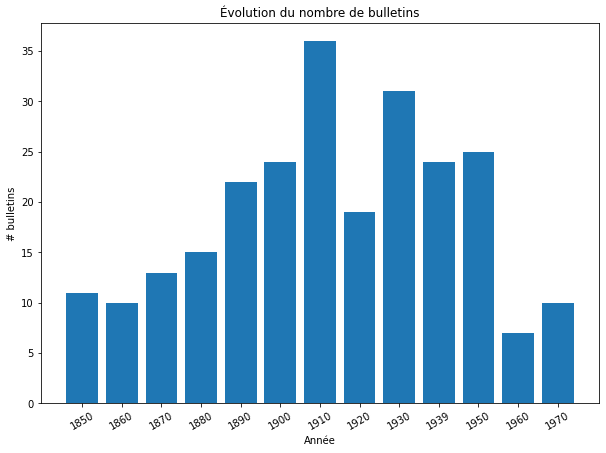

In [24]:
index = np.arange(len(count_files_year))
plt.bar(index, count_files_year.values())
plt.xlabel('Année')
plt.ylabel('# bulletins')
plt.xticks(index, count_files_year.keys(), fontsize=10, rotation=30)
plt.title('Évolution du nombre de bulletins')
plt.rcParams["figure.figsize"] = (15,7)
plt.show()

## Reconnaissance d'entités nommées 

### Creer une liste de stop words

In [25]:
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", 
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "q u i", "Messieurs", "q u '", "D e P", "Page", 
       "Médicamens", "u r r i", "Enraisonde", "o p fa", "D E J", "lle5la", "Dépôt", 
       "É V A L U A T I O N DES T E", "j o u r", "Amortissement", "i v i", "Pardon", "W Y I V S DE",
       "Discussion", "u vernement", "q u ' i", "é t a i", "q u e", "Celte", "Veuillez", "e u r",
       "u i r", "v o i r", "Proposition", "D o u c e t", "i c i", "Subside", "o u i", "u i t", "Carreau",
       "Paiemens", "r i e", "é t a i r", "i t - i l", "o u v r i r", "u j o u r", "Passons", "Voyons",
       "t e r r", "Légumes", "Déjà", "j u g é", "bon v o u", "u t i o", "é d i", "q u i d", "é r e r",
       "contre-avis", "u t i l e", "i v i d u", "reclus", "p o u r", "Recettes", "c. Amortissement",
       "^ Moyennant", "advînt", "Agneessens", "apet", "çenè", "Phospiee", "u i<v", "Voulez", "o u r r",
       "D e H", "P r é", "qucnce", "CHARGES SUR", "Année", "Montant du Sans", "Imputations", "Cercueils",
       "Avances", "Recommander", "u r r", "Layettes", "u s i e u r", "v e i", "u collège", "Prorogation",
       "ldiers", "Interpellation", "Monnaie", "r i r", "pèitl parfahçmenl", "mnrcfcé", "u i v r", "Naguère",
       "hôpital Saint-Jean", "Abordant", "Faudra", "quesais", "v e r", "vcrdui ière", "u p r i x", 
       "Vieux-Marché", "j o u", "Démission", "i q u é", "50 c.", "û t e r", "q u e !", "u r é", "u v r i r",
       "q u i c o", "c i r c u", "v i e r", "RESULTATS DE L'OPERATION AU BOUT DE", "pour24 ans", "soieni",
       "i v i sion", "Décentraliser", "u i q u i", "halle", "loué", "Patriarches", "vdle", "messieurs",
       "auxrenseignemens", "dessein", " Gross", "Fruits", "Cellierss", "a u j o", "270,785 f r",
       "u Marché-aux-Herbes", "payât", "G/10s", "u j o", "q u ' a r r i v e r a - t - i", "u Collège",
       "Tromper", "Distribution", "F. de Page", "u mont-de-piété", "u i v", "v i e r d e r", "mon i",
       "Troplong", "Prétendra", "Pusage", "arB   ", "Contiendra", "eYst", "Comp", "Communication", "î f l",
       "Voté apparait", "embellissemens", "u vestibule d", "naie", "lllaes", "BAR-", "L'auteur", "Paradis",
       "Abonnemens", "Maintenez", "vientde", "Parterre", "S6,000", "couronnas", "vousmêmes", "Reste", "rétendue"]
sw = set(sw)

In [26]:
print(f"{len(sw)} stopwords")

365 stopwords


### Appliquer la reconnaissance d'entités nommées PER

In [27]:
people = defaultdict(int)

nlp = spacy.load('fr_core_news_md')

In [29]:
%%time

files_with_entities = defaultdict(dict)

for file in files:
    # Dictionnaire de dictionnaire : contient comme key le nom du file, et le valeur est un dictionnaire avec les entités comme key et sa fréquence comme valeur
    files_with_entities[file] = defaultdict(int)
    path = join(dirname, file)
    #print('path', path)
    with open(path, encoding='utf-8') as f:
        text = f.read()
        doc = nlp(text)
        for ent in doc.ents:
            if ent.label_ == "PER" and len(ent.text) > 3 and ent.text not in sw:
                files_with_entities[file][ent.text] += 1
                people[ent.text] += 1
        #print(files_with_entities)

#print("finished!")
#print(files_with_entities())

CPU times: user 1h 26min 2s, sys: 5min 54s, total: 1h 31min 57s
Wall time: 1h 33min 49s


In [30]:
# Nombre d'entités trouvées
len(people.keys())

42775

## Détection d'erreurs d'OCR dans la reconnaissance d'entités nommées

### Détection non automatique d'erreurs OCR

In [49]:

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)

# Trouver mots -> entités qui sont du style 'e t a', 'a l ^', 'o u a l'
def is_not_ocr_error(word):
    for w in word.split(" "):
        if len(w) > 1:
            return True

    return False

# Filtrer les mots sans l'erreur d'OCR trouvé
sorted_people = list(filter(lambda x: is_not_ocr_error(x[0]), sorted_people))

#map fonction pour detecter le 1er element de la tuple
names = list(map(lambda x: x[0], sorted_people))
repeated = defaultdict(list)


In [56]:
len(names)

38100

### Détection automatique d'erreurs OCR et regrouper les entités selon la similarité

In [57]:
# Lister/grouper les mots considérés comme synonymes = fuzz.ratio > 75 
for name in names:
    repeated[name] = list()
    for other_name in names:
        if name != other_name:
            ratio = fuzz.ratio(name, other_name)
            # 75 Ç'est un bon numéro de manière général, sauf pour le mot "Bourgmestre"
            if ratio >= 75: 
                repeated[name].append(other_name)
            

print(list(repeated.keys())[:50])

['Bourgmestre', 'M. le Bourgmestre', 'Mesdames', 'Echevin', 'Brunfaut', 'Lepage', 'Richald', 'Budget', 'Bochart', 'Vermeire', 'De Mot', 'Considérant', 'Echevins', 'M. Brunfaut', 'Speeckaert', 'Secrétaire', 'Le Secrétaire', 'Vauthier', "M. l'Echevin", 'Catteau', 'Lemonnier', 'Godefroy', 'Verheven', 'Camille Huysmans', 'Depaire', 'Hubert', 'Foucart', 'Montant', 'Bauwens', 'Fabrique', 'Deboeck', 'Président', 'Joseph', 'Legs', 'Monsieur le Bourgmestre', 'Thonet', 'Observations', 'Moyson', 'Loyer', 'Conrardy', 'Linotte', 'Vandendorpe', 'Jean', 'Schmitz', 'Louise', 'Lalemand', 'Bischoffsheim', 'Adoption', 'Schalckens', 'Propriétés']


## Nettoyage des entités trouvées 

### Déduplication de groupe d'entités similaires

In [58]:
# Garder un set()  avec les mots déjà traités pour ne pas les traiter plus d'une fois
processed = set() 

# Sommer la frequence d'un mot et ses synonymes
dedup = {} 

# Traiter 
for word, synonyms in repeated.items():
    # Si un mot n'a pas été traité
    if (word not in processed and word != "Bourgmestre"): # hack
        dedup[word] = next(x for x in sorted_people if x[0] == word)[1]
        
        processed.add(word)
        for w in synonyms:
            e = next(x for x in sorted_people if x[0] == w)[1]
            dedup[word] += e
            processed.add(w)

#print(dedup[:50])

print(list(dedup.keys())[:50])
    

['M. le Bourgmestre', 'Mesdames', 'Echevin', 'Brunfaut', 'Lepage', 'Richald', 'Budget', 'Bochart', 'Vermeire', 'De Mot', 'Considérant', 'Speeckaert', 'Secrétaire', 'Vauthier', "M. l'Echevin", 'Catteau', 'Lemonnier', 'Godefroy', 'Verheven', 'Camille Huysmans', 'Depaire', 'Hubert', 'Foucart', 'Montant', 'Bauwens', 'Fabrique', 'Deboeck', 'Président', 'Joseph', 'Legs', 'Thonet', 'Observations', 'Moyson', 'Loyer', 'Conrardy', 'Linotte', 'Vandendorpe', 'Jean', 'Schmitz', 'Louise', 'Lalemand', 'Bischoffsheim', 'Adoption', 'Schalckens', 'Propriétés', 'Fontainas', 'Entretien', 'Anspach', 'Theodor', 'Monsieur']


In [59]:
len(dedup.keys())

22964

In [62]:
print(list(dedup.keys())[:50])

['M. le Bourgmestre', 'Mesdames', 'Echevin', 'Brunfaut', 'Lepage', 'Richald', 'Budget', 'Bochart', 'Vermeire', 'De Mot', 'Considérant', 'Speeckaert', 'Secrétaire', 'Vauthier', "M. l'Echevin", 'Catteau', 'Lemonnier', 'Godefroy', 'Verheven', 'Camille Huysmans', 'Depaire', 'Hubert', 'Foucart', 'Montant', 'Bauwens', 'Fabrique', 'Deboeck', 'Président', 'Joseph', 'Legs', 'Thonet', 'Observations', 'Moyson', 'Loyer', 'Conrardy', 'Linotte', 'Vandendorpe', 'Jean', 'Schmitz', 'Louise', 'Lalemand', 'Bischoffsheim', 'Adoption', 'Schalckens', 'Propriétés', 'Fontainas', 'Entretien', 'Anspach', 'Theodor', 'Monsieur']


## Statistiques des entités nomées

### Évolution des entités nommées au fil des ans

In [121]:
# files_with_entities est un dictionnaire de dictionnaire : contient comme key le nom du file, 
# et le valeur est un dictionnaire avec les entités comme key et sa fréquence comme valeur
i = 0

for item in files_with_entities:
    if i < 1 :
        print(item, files_with_entities[item])
        i += 1

Bxl_1850_Tome_I1_Part_1.txt defaultdict(<class 'int'>, {'Panoramas': 1, 'Fourniture': 3, 'Le Secrétaire': 5, 'Présidence de M': 2, 'Autorisation': 7, 'M. Téchcvin Hlaes': 1, 'Maintien': 1, 'Capouillet': 4, 'De Meure': 1, 'De V': 4, 'Humbeeck': 2, 'Vandermeeren': 5, 'Bischoffssheim': 1, 'Doucet': 5, 'u teur': 1, 'Lettre': 1, 'u moyen-àge': 1, 'u t e u': 4, 'P o u r': 2, 'Delaveleye': 1, 'u t i': 4, "q u ' u": 12, 'c e r t a i': 1, 'r u d e v o i r casser': 1, 'u g o u v': 1, 'u c u': 3, 'r i v': 2, 'p o u': 6, 'Sevestre': 1, 'u Cercle': 1, 'Hegcr': 1, "u q u ' e": 1, 'u t a i': 1, 'u r M': 1, 'q u i a r e': 1, 'u v r': 1, 'q u i p o u r r': 1, 'f i t e': 1, 'q u e s': 2, 'i q u': 5, 'd e r': 1, "q u ' e": 7, 'v i g': 1, 'Diminution': 1, 'j u i': 4, 'Jean-Baptiste D e c': 1, 'Jeanne-Marie V': 1, 'u Marché': 3, 'Poisson': 2, 'u c t i o': 1, 'u r d r o i t': 1, 'e v r': 4, 'u d e r': 1, 'a u c u': 1, 'u p a i': 1, 'q j o': 3, 'r o i t': 6, 'q u i ne r': 1, 'u r i': 1, 'u v e r t u r e': 2,

### Détecter la fréquence des entités nommées et la fréquence total, par année

In [88]:
# Nombre d'entités sur chaque année
entities_per_year = {}

# Somme de toutes les répétitions de toutes les entités par an
frequencies_per_year = {}

for (file, entities) in files_with_entities.items():
    # Detecter l'année du nom de fichier
    year = file.split("_")[1]
    
    # Chaque année, le nombre d'entités correspond au nombre de clés dans le dictionnaire
    entities_per_year[year] = len(entities.keys())
    
    # Itérer sur toutes les valeurs et les sommer
    frequencies = 0
    for freq in entities.values():
        frequencies += freq
    frequencies_per_year[year] = frequencies

print(entities_per_year)
print(frequencies_per_year)

{'1850': 60, '1860': 63, '1870': 189, '1880': 542, '1890': 356, '1900': 155, '1910': 87, '1920': 548, '1930': 140, '1939': 180, '1950': 46, '1960': 320, '1970': 932}
{'1850': 69, '1860': 81, '1870': 317, '1880': 664, '1890': 1191, '1900': 340, '1910': 149, '1920': 630, '1930': 269, '1939': 281, '1950': 50, '1960': 403, '1970': 1028}


### Graphique de l'évolution des entités trouvées par année

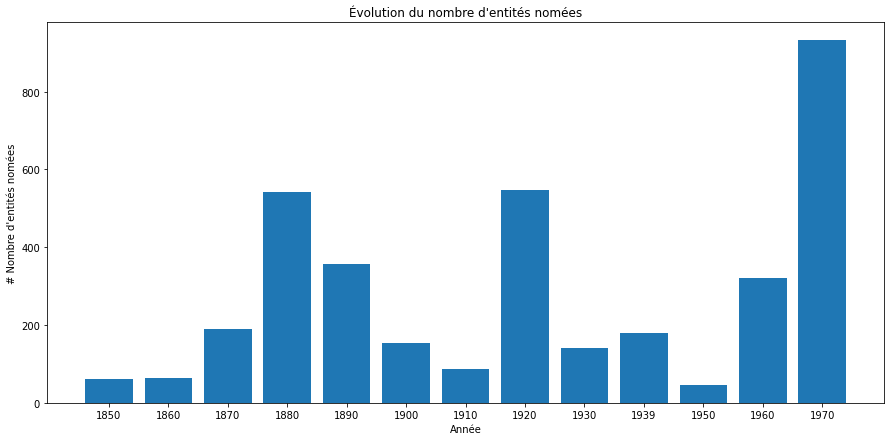

In [94]:
plt.bar(range(len(entities_per_year)), list(entities_per_year.values()), align='center')
plt.xticks(range(len(entities_per_year)), list(entities_per_year.keys()))
plt.xlabel('Année')
plt.ylabel("# Nombre d'entités nommées")
plt.title("Evolution du nombre d'entités nommées")
plt.show()

### Graphique de l'évolution de la fréquence des entités trouvées par an

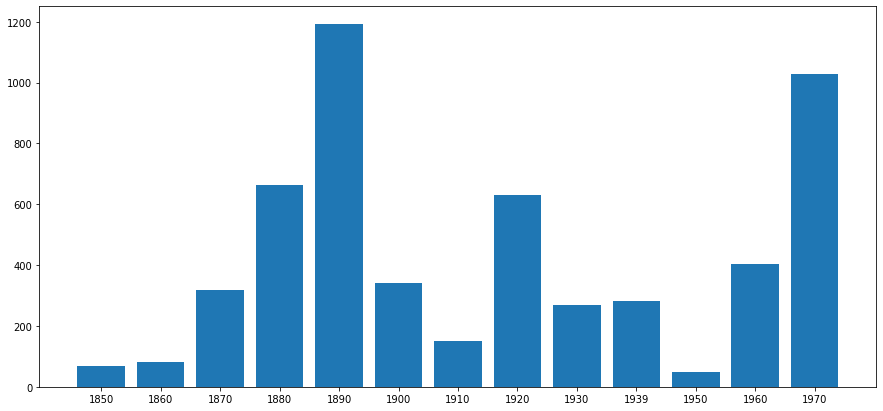

In [93]:
plt.bar(range(len(frequencies_per_year)), list(frequencies_per_year.values()), align='center')
plt.xticks(range(len(frequencies_per_year)), list(frequencies_per_year.keys()))
plt.xlabel('Année')
plt.ylabel("# fréquence d'apparition des entités nomées")
plt.title("Évolution du nombre d'entités nommées")
plt.show()

## Moteur de recherche des entités les plus nommées

### Fréquence, nombre de fichiers dans lesquels il apparaît et taux d'apparition des entités

In [116]:
entities_file = defaultdict(set)

for (file, entities) in files_with_entities.items():
    for entity in entities.keys():
        entities_file[entity].add(file)

result = []
for (entity, freq) in sorted_people[:50]:
    result.append((entity, freq, entities_file[entity], freq / len(entities_file[entity])))

# Print entité, fréquence, nombre de fichiers dans lesquels il apparaît et ratio d'apparition
print(list(map(lambda x: (x[0], x[1], len(x[2]), x[3]), result)))

[('Bourgmestre', 3837, 212, 18.099056603773583), ('M. le Bourgmestre', 2309, 146, 15.815068493150685), ('Mesdames', 1730, 59, 29.322033898305083), ('Echevin', 1375, 178, 7.724719101123595), ('Brunfaut', 842, 55, 15.309090909090909), ('Lepage', 827, 89, 9.292134831460674), ('Richald', 805, 29, 27.75862068965517), ('Budget', 704, 128, 5.5), ('Bochart', 686, 13, 52.76923076923077), ('Vermeire', 630, 60, 10.5), ('De Mot', 547, 63, 8.682539682539682), ('Considérant', 525, 66, 7.954545454545454), ('Echevins', 421, 128, 3.2890625), ('M. Brunfaut', 402, 46, 8.73913043478261), ('Speeckaert', 399, 40, 9.975), ('Secrétaire', 395, 145, 2.7241379310344827), ('Le Secrétaire', 390, 66, 5.909090909090909), ('Vauthier', 387, 36, 10.75), ("M. l'Echevin", 377, 76, 4.9605263157894735), ('Catteau', 377, 58, 6.5), ('Lemonnier', 355, 60, 5.916666666666667), ('Godefroy', 343, 44, 7.795454545454546), ('Verheven', 331, 70, 4.728571428571429), ('Camille Huysmans', 330, 26, 12.692307692307692), ('Depaire', 325, 6

### Découvrir dans quels fichiers une entité est nommée

In [122]:
name = "Camille Huysmans"

def search(n):
    for (word, _, files, _) in result:
        if (word == n):
            return files
    return "Not found"

print(search(name))

{'Bxl_1910_Tome_I2_2_Part_6.txt', 'Bxl_1910_Tome_I2_1_Part_6.txt', 'Bxl_1910_Tome_I1_Part_6.txt', 'Bxl_1910_Tome_I2_1_Part_7.txt', 'Bxl_1920_Tome_I2_Part_19.txt', 'Bxl_1910_Tome_I2_2_Part_7.txt', 'Bxl_1910_Tome_I2_2_Part_12.txt', 'Bxl_1910_Tome_I2_2_Part_4.txt', 'Bxl_1910_Tome_I2_1_Part_4.txt', 'Bxl_1910_Tome_I1_Part_4.txt', 'Bxl_1910_Tome_I1_Part_3.txt', 'Bxl_1920_Tome_I2_Part_14.txt', 'Bxl_1920_Tome_I2_Part_12.txt', 'Bxl_1910_Tome_I1_Part_1.txt', 'Bxl_1910_Tome_I1_Part_2.txt', 'Bxl_1910_Tome_I1_Part_5.txt', 'Bxl_1910_Tome_I2_2_Part_3.txt', 'Bxl_1930_Tome_II2_Part_3.txt', 'Bxl_1910_Tome_I2_2_Part_2.txt', 'Bxl_1920_Tome_I2_Part_18.txt', 'Bxl_1920_Tome_I2_Part_13.txt', 'Bxl_1910_Tome_I2_1_Part_5.txt', 'Bxl_1910_Tome_I1_Part_7.txt', 'Bxl_1910_Tome_I2_1_Part_1.txt', 'Bxl_1910_Tome_I2_2_Part_5.txt', 'Bxl_1920_Tome_I2_Part_1.txt'}
